In [2]:
# First off - load all python libraries we are going to need
import pandas as pd
import numpy as np
import os
#import plotly.plotly as py
#import plotly.graph_objs as go


from google.colab import auth
from google.cloud import bigquery
from google.colab import files

import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
import matplotlib.dates as mdates



from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
!pip install regressors
from regressors import stats    


from sklearn.impute import SimpleImputer

from sklearn import metrics

import statsmodels.api as sm

# !pip install pygam
# from pygam import GAM, s, l , te ,LogisticGAM, LinearGAM

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

# !pip install zepid
# import zepid as zp

#import plotly
#plotly.tools.set_credentials_file(username='harounchahed', api_key='ZHypTc119csyz5p0xWet')

  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=51df2aef1499aacc7201ea51204452e2f5d87a51ab10a5df250c622549deb475
  Stored in directory: /root/.cache/pip/wheels/b2/89/fc/7867f77234d0033395f7ad9814f245b337139acaa06b085aa2
Successfully built regressors


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
MSM_table_1H = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table24_1H.csv"
MSM_table_2H = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table24_2H.csv"
MSM_table_3H = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table24_3H.csv"
MSM_table_4H = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table24_4H.csv"
MSM_table_5H = "/content/drive/My Drive/Colab Notebooks/Capstone/MSM_table24_5H.csv"

MSM_table_1H = pd.read_csv(MSM_table_1H)
MSM_table_2H = pd.read_csv(MSM_table_2H)
MSM_table_3H = pd.read_csv(MSM_table_3H)
MSM_table_4H = pd.read_csv(MSM_table_4H)
MSM_table_5H = pd.read_csv(MSM_table_5H)
# Dataset is now stored in a Pandas Dataframe

In [5]:
MSM_table_5H.shape

(43799, 45)

In [6]:
MSM_table_1H[MSM_table_1H.ICU30_death == 1]

,Unnamed: 0,subject_id,hadm_id,icustay_id,Spo2,Fio2,SF_ratio,NMBA_count,tr_t,tr_t_min_1,admittime,dischtime,intime,outtime,mv_durations_hours_y,mv_starttime_y,mv_endtime_y,min_pao2fio2,max_peep,age,dod,los,weight,height,BMI,admission_type,admission_location,LANGUAGE,religion,marital_status,ethnicity,diagnosis,female,oasis,elixhauser,explicit_sepsis,vaso,mortality,den,nom,IPTW,ICU_death,hos_death,ICU30_death,ICU90_death
47,47,10694.0,138159.0,294193.0,93.0,60.000000,1.550000,NaN,0,0,2153-08-11 20:58:00,2153-08-27 15:35:00,2153-08-11 20:59:05,2153-08-27 16:58:11,350.00000,2153-08-12 02:00:00,2153-08-26 16:00:00,43.00000,20.0,88.0,2153-08-27,15.8327,71.40,162.56,27.0,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,JEWISH,MARRIED,WHITE,POST ARREST ? SEPSIS,1,56,23,1,1,1,0.903654,0.958808,1.061035,1,1,1,1
287,287,56583.0,138864.0,204061.0,98.0,80.000000,1.225000,NaN,0,0,2161-04-29 23:45:00,2161-05-16 00:00:00,2161-04-29 23:45:44,2161-05-16 02:07:27,378.00000,2161-04-30 06:00:00,2161-05-16 00:00:00,133.33333,10.6,85.0,2161-05-16,16.0984,75.30,180.00,23.2,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,RESPIRATORY FAILURE,0,55,19,1,1,1,0.791813,0.932517,1.177699,1,0,1,1
311,311,58865.0,176110.0,222432.0,100.0,50.000000,2.000000,NaN,0,0,2146-12-06 07:15:00,2146-12-10 18:05:00,2146-12-06 12:46:18,2146-12-10 20:13:04,100.50000,2146-12-06 18:00:00,2146-12-10 22:30:00,60.00000,10.6,78.0,2146-12-10,4.3103,83.46,182.88,25.0,ELECTIVE,PHYS REFERRAL/NORMAL DELI,ENGL,UNOBTAINABLE,DIVORCED,WHITE,RECTAL CANCER/SDA,0,35,8,0,1,1,0.950696,0.949698,0.998950,1,1,1,1
383,383,70119.0,130951.0,282669.0,99.0,50.000000,1.980000,NaN,0,0,2149-12-31 15:56:00,2150-01-05 02:00:00,2149-12-31 15:57:08,2150-01-05 04:30:33,96.08333,2149-12-31 22:15:00,2150-01-04 22:20:00,98.33333,10.5,45.0,2150-01-05,4.5232,84.40,183.00,25.2,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT SPECIFIED,S/P CARDIAC ARREST,0,35,16,0,1,1,0.950204,0.888248,0.934797,1,1,1,1
542,542,83351.0,192751.0,275950.0,99.0,50.000000,1.980000,NaN,0,0,2185-02-15 23:07:00,2185-02-20 11:51:00,2185-02-18 09:15:05,2185-02-20 14:41:11,22.30000,2185-02-18 18:00:00,2185-02-19 16:18:00,70.00000,16.0,55.0,2185-02-20,2.2265,139.00,183.00,41.5,EMERGENCY,CLINIC REFERRAL/PREMATURE,ENGL,JEWISH,MARRIED,WHITE,ACUTE CORONARY SYNDROME,0,33,2,0,1,1,0.966929,0.942967,0.975219,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73694,73694,21521.0,196977.0,268210.0,84.0,60.000002,1.400000,NaN,0,0,2190-08-28 06:18:00,2190-08-29 13:11:00,2190-08-28 06:19:00,2190-08-29 13:11:00,22.63333,2190-08-28 16:00:00,2190-08-29 14:38:00,95.00000,5.0,82.0,2190-08-29,1.2861,74.80,NaN,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,NaN,NOT SPECIFIED,MARRIED,WHITE,COLITIS-URINARY TRACT INFECTION,0,66,5,0,1,1,0.973780,0.981806,1.008243,1,1,1,1
73700,73700,19604.0,152041.0,230968.0,98.0,50.000000,1.960000,NaN,0,0,2195-01-02 19:46:00,2195-01-08 10:40:00,2195-01-05 01:10:08,2195-01-08 06:36:31,7.00000,2195-01-05 06:00:00,2195-01-05 13:00:00,97.00000,5.0,80.0,2195-01-11,3.2267,127.00,NaN,NaN,EMERGENCY,TRANSFER FROM SKILLED NUR,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,UROSEPSIS,1,38,13,0,0,1,0.990273,0.998576,1.008384,0,0,1,1
73719,73719,16894.0,122090.0,250092.0,100.0,50.000000,2.000000,NaN,0,0,2118-02-25 02:00:00,2118-03-15 13:15:00,2118-02-25 04:01:33,2118-03-15 21:15:57,8.83333,2118-02-25 13:00:00,2118-02-25 21:50:00,117.77778,17.0,70.0,2118-03-15,18.7183,61.30,170.18,21.2,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,ABDOMINAL AORTIC ANEURYSM,1,45,23,0,1,1,0.992762,0.989701,0.996917,1,1,1,1
73733,73733,84914.0,198880.0,283447.0,95.0,50.000000,1.900000,NaN,0,0,2116-08-10 08:00:00,2116-08-15 21:10:00,2116-08-10 17:04:30,2116-08-15 22:47:49,14.66667,2116-08-10 22:00:00,2116-08-11 12:40:00,148.00000,5.5,66.0,2116-08-15,5.2384,6

## Structural Model

In [0]:
def truncate(MSM_table, p):
  MSM_table_trunc = MSM_table.copy()
  MSM_table_trunc.IPTW = np.where(MSM_table_trunc.IPTW >= MSM_table_trunc.IPTW.quantile(1 - p), MSM_table_trunc.IPTW.quantile(1 - p), MSM_table_trunc.IPTW)
  MSM_table_trunc.IPTW = np.where(MSM_table_trunc.IPTW <= MSM_table_trunc.IPTW.quantile(p), MSM_table_trunc.IPTW.quantile(p), MSM_table_trunc.IPTW)
  return MSM_table_trunc

In [0]:
def structural_model(MSM_table, p, interval):
  MSM_table_trunc = truncate(MSM_table, p)
  X = sm.add_constant(MSM_table_trunc[['tr_t_min_1', 'age', 'female', 	'oasis',	'elixhauser',	'explicit_sepsis',	'vaso']])
  y = MSM_table_trunc['ICU30_death']

  # Instantiate a binomial family model with the logit function.
  MSM_model = sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit, freq_weights=MSM_table_trunc.IPTW.astype(np.float64))
  # MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

  MSM_result = MSM_model.fit
  print("\n\nFor " + str(interval) + " and p = " + str(p) + " with IPTW mean " + str(MSM_table_trunc.IPTW.mean()))
  print(MSM_result.summary())
  return MSM_result

In [0]:
truncate_range = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

In [61]:
for p in truncate_range: 
  structural_model(MSM_table_1H, p, '1H')

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)




For 1H and p = 0 with IPTW mean 262.7032350774857
                 Generalized Linear Model Regression Results                  
Dep. Variable:            ICU30_death   No. Observations:                73794
Model:                            GLM   Df Residuals:              19385914.53
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3225e+05
Date:                Thu, 26 Mar 2020   Deviance:                   4.6450e+05
Time:                        15:41:20   Pearson chi2:                 2.60e+06
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [62]:
for p in truncate_range: 
  structural_model(MSM_table_2H, p, '2H')

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)




For 2H and p = 0 with IPTW mean 484.66961468771115
                 Generalized Linear Model Regression Results                  
Dep. Variable:            ICU30_death   No. Observations:                64235
Model:                            GLM   Df Residuals:              31132744.70
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9558e+06
Date:                Thu, 26 Mar 2020   Deviance:                   3.9117e+06
Time:                        15:41:43   Pearson chi2:                 5.95e+06
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [63]:
for p in truncate_range: 
  structural_model(MSM_table_3H, p, '3H')

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)




For 3H and p = 0 with IPTW mean 8.82628097607918
                 Generalized Linear Model Regression Results                  
Dep. Variable:            ICU30_death   No. Observations:                57687
Model:                            GLM   Df Residuals:                509153.67
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4295e+05
Date:                Thu, 26 Mar 2020   Deviance:                   2.8591e+05
Time:                        15:41:58   Pearson chi2:                 4.13e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [64]:
for p in truncate_range: 
  structural_model(MSM_table_4H, p, '4H')

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)




For 4H and p = 0 with IPTW mean 2.9340702199438686
                 Generalized Linear Model Regression Results                  
Dep. Variable:            ICU30_death   No. Observations:                52529
Model:                            GLM   Df Residuals:                154115.77
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63312.
Date:                Thu, 26 Mar 2020   Deviance:                   1.2662e+05
Time:                        15:42:08   Pearson chi2:                 1.75e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe83a38f828>],
 'cbars': <matplotlib.collections.LineCollection at 0x7fe83a32a278>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe83a38fcf8>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7fe83a38f7f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe83a38ff98>,
 'cquantiles': <matplotlib.collections.LineCollection at 0x7fe83a32a518>}

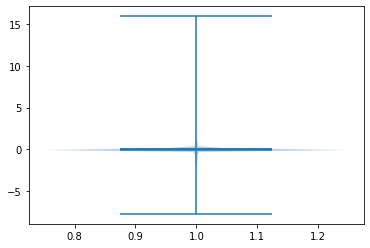

In [14]:
plt.violinplot(np.log(MSM_table_1H.IPTW),
                     showmeans=True, showextrema=True, showmedians=False,
                      quantiles=[0.05,0.95])

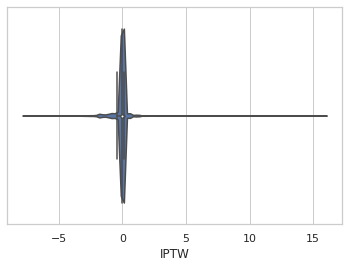

In [15]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(x=np.log(MSM_table_1H.IPTW))
ax = sns.boxplot(x=np.log(MSM_table_1H.IPTW), showfliers=False, showbox=False, whis=[2.5,97.5])

In [0]:
MSM_table_1H_trunc = truncate(MSM_table_1H , 0.01)

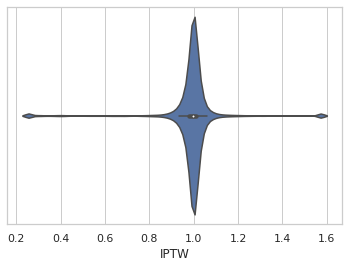

In [17]:
ax = sns.violinplot(x=MSM_table_1H_trunc.IPTW)

Negative age investigation

In [0]:
test = MSM_table_1H.groupby(MSM_table_1H.icustay_id).max()

In [69]:
X = sm.add_constant(test.age)
y = test.ICU30_death

# Instantiate a binomial family model with the logit function.
MSM_model = sm.Logit(y, X) #sm.GLM(y, X, family = sm.families.Binomial(), links = sm.genmod.families.links.logit) # freq_weights=MSM_table_1H.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()
predicted_y = MSM_result.predict(sm.add_constant(test.age))
print(MSM_result.summary())

Optimization terminated successfully.
         Current function value: 0.573570
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            ICU30_death   No. Observations:                 3726
Model:                          Logit   Df Residuals:                     3724
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.01297
Time:                        16:18:29   Log-Likelihood:                -2137.1
converged:                       True   LL-Null:                       -2165.2
Covariance Type:            nonrobust   LLR p-value:                 6.672e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1507      0.163    -13.159      0.000      -2.471      -1.830
age            0.0178      0.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


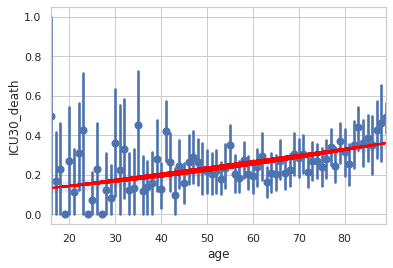

In [70]:
ax = sns.regplot(x="age", y="ICU30_death", data=test, logistic=True, x_estimator=np.mean)
ax = plt.plot(test.age, predicted_y, color = 'red')

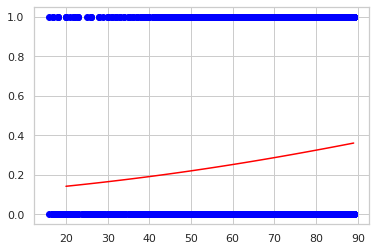

In [67]:
plt.plot(range(20,90), predicted_y, color = 'red')
# plt.plot(test.age, np.log(predicted_y/(1-predicted_y)), color = 'green')
plt.scatter(test.age, test.ICU30_death, color = 'blue')

In [0]:
# plt.scatter(test.age,test.ICU30_death)
# # plt.plot(age_table.index, predicted_y, color = 'red')
# plt.xlabel("age")
# plt.ylabel("30 day mortality ICU")

In [0]:
test.age

In [0]:
tips = sns.load_dataset("tips")
tips

In [0]:
X = age_table.index
y = age_table.ICU30_death

# Instantiate a binomial family model with the logit function.
MSM_model = sm.GLM(y, X)#, family = sm.families.Binomial() , links = sm.genmod.families.links.logit)#, freq_weights=bigger16.IPTW.astype(np.float64))
# MSM_model = sm.GLM(y, X, links = sm.genmod.families.links.logit, freq_weights = MSM_table.IPTW.astype(np.float64))

MSM_result = MSM_model.fit()
predicted_y = MSM_result.predict(X)
print(MSM_result.summary())